Group Members

Lohith Reddy Tamma(Lt268)
Achutha Sreenivas Mullapudi(am3687)
Vijaya Sravani Balemarthi(vb467)

In [1]:
!pip install xgboost

In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_data = pd.read_csv("house-prices-advanced-regression-techniques/train.csv")
test_data = pd.read_csv("house-prices-advanced-regression-techniques/test.csv")

Add a new feature named 'TotalSF' to both the train and test datasets by summing the square footage of the basement, first floor, and second floor.

In [4]:
# Add a new feature named 'TotalSF' to the train data by summing the square footage of the basement, first floor, and second floor.
train_data['TotalSF'] = train_data['TotalBsmtSF'] + train_data['1stFlrSF'] + train_data['2ndFlrSF']

# Add a new feature named 'TotalSF' to the test data by summing the square footage of the basement, first floor, and second floor.
test_data['TotalSF'] = test_data['TotalBsmtSF'] + test_data['1stFlrSF'] + test_data['2ndFlrSF']


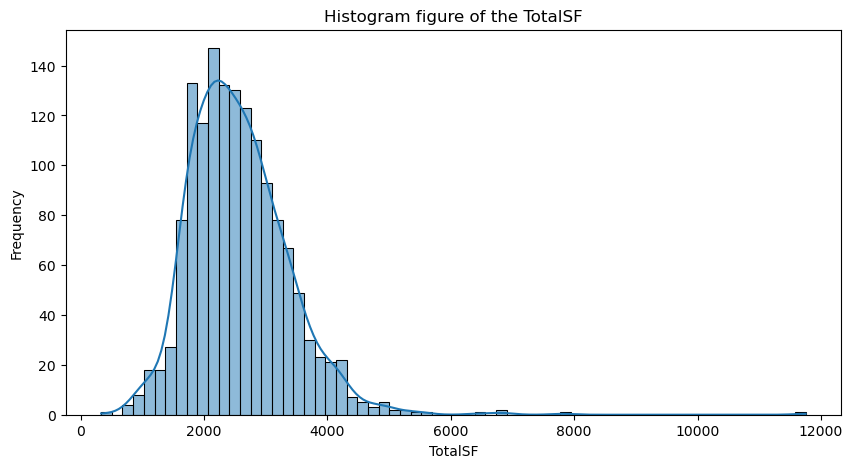

In [5]:
# Set up the figure size for the histogram plot
plt.figure(figsize=(10, 5))

# Generate a histogram of the 'TotalSF' feature from the train dataset, with an overlaid kernel density estimate (KDE).
sns.histplot(train_data["TotalSF"], kde=True)

# Title of the plot
plt.title("Histogram figure of the TotalSF")

# Label for the x-axis of the plot
plt.xlabel("TotalSF")

# Label for the y-axis of the plot
plt.ylabel("Frequency")

# Display the plot
plt.show()

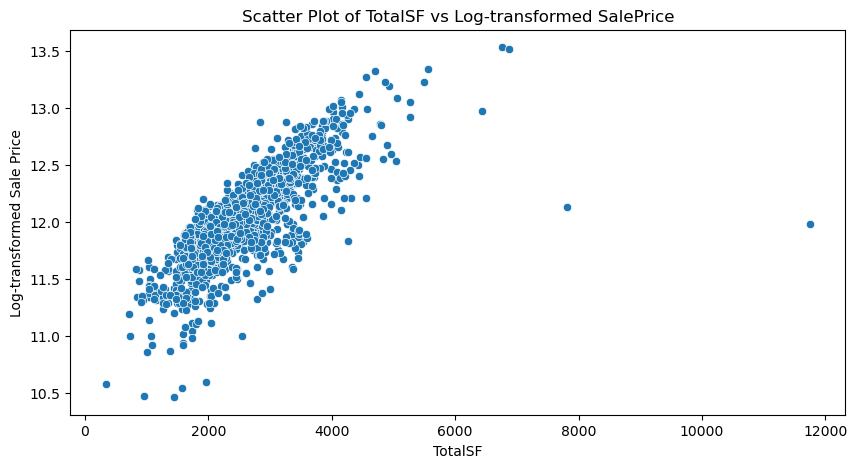

In [6]:
# Figure size for the scatter plot
plt.figure(figsize=(10, 5))

# Create a scatter plot of TotalSF against the log-transformed SalePrice using Seaborn
# The 'x' parameter represents the TotalSF feature, while the 'y' parameter corresponds to the SalePrice feature after applying the natural logarithm transformation
# The 'data' parameter specifies the DataFrame, where a new column "SalePrice" in train_df contains the log-transformed values of the SalePrice column
sns.scatterplot(x="TotalSF", y="SalePrice", data=train_data.assign(SalePrice=np.log(train_data["SalePrice"])))

# Title of the plot
plt.title("Scatter Plot of TotalSF vs Log-transformed SalePrice")

# Label for the x-axis of the plot
plt.xlabel("TotalSF")

# Label for the y-axis of the plot
plt.ylabel("Log-transformed Sale Price")

# Display the plot
plt.show()


In [7]:
train_data = train_data[train_data['TotalSF'] < 6000]

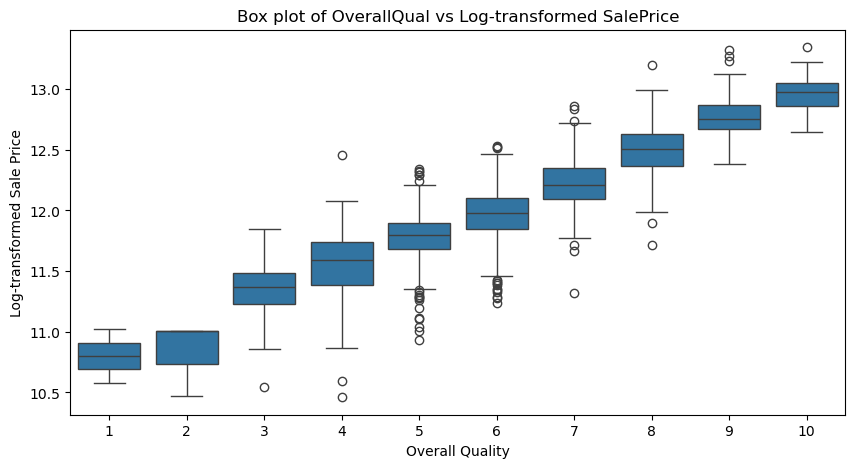

In [8]:
# Figure size for the box plot
plt.figure(figsize=(10, 5))

# Generate a box plot of OverallQual versus the log-transformed SalePrice using Seaborn
# The 'x' parameter represents the OverallQual feature, and the 'y' parameter represents the SalePrice feature after applying a natural logarithm transformation
# The 'data' parameter specifies the DataFrame, with a new column named "SalePrice" in train_df containing the log-transformed values of the SalePrice column
sns.boxplot(x="OverallQual", y="SalePrice", data=train_data.assign(SalePrice=np.log(train_data["SalePrice"])))

# Title of the plot
plt.title("Box plot of OverallQual vs Log-transformed SalePrice")

# Label for the x-axis of the plot
plt.xlabel("Overall Quality")

# Label for the y-axis of the plot
plt.ylabel("Log-transformed Sale Price")

# Display the plot
plt.show()


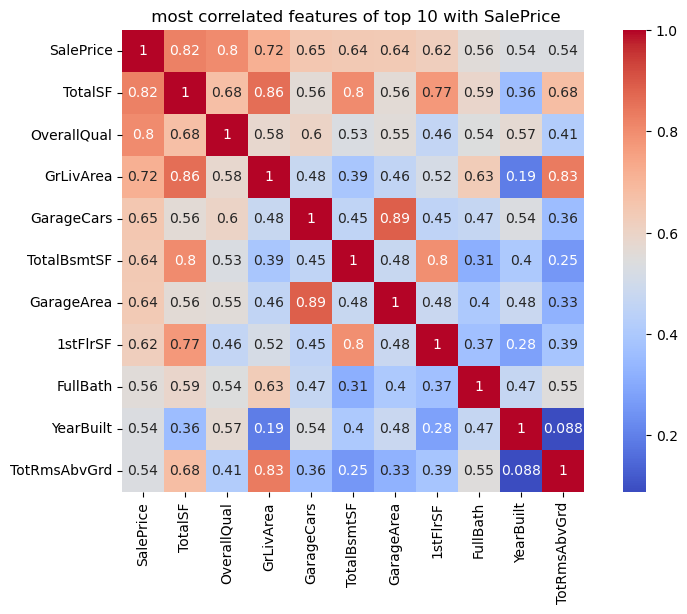

In [9]:
# Drop non-numeric columns
numeric_columns = train_data.select_dtypes(include=[np.number]).columns
train_data_numeric = train_data[numeric_columns]

# Compute correlation matrix
corr_matrix = train_data_numeric.corr()

# Get top correlated features with SalePrice
top_corr_features = corr_matrix.nlargest(11, "SalePrice")["SalePrice"].index

# Create a heatmap using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(train_data_numeric[top_corr_features].corr(), annot=True, cmap="coolwarm", square=True)
plt.title(" most correlated features of top 10 with SalePrice")
plt.show()


The plot above shows the top 10 features with the strongest correlation to SalePrice. Initially, I focused on using only these features, assuming they were the most critical predictors for the target variable. However, the results were less effective than anticipated. As a result, I decided to include all features instead.

I created a function named preprocess_data to handle data preprocessing tasks, such as removing the 'Id' column (if it exists) and separating numerical and categorical features. This function was applied to both the train and test datasets, and the processed data was stored in new variables.

In [10]:
def preprocess_data(daf, is_train=True):
    if "Id" in daf.columns:
        daf = daf.drop(["Id"], axis=1)
    num_features = daf.select_dtypes(include=[np.number]).columns
    cat_features = daf.select_dtypes(include=[object]).columns

    if is_train:
        num_features = num_features.drop("SalePrice")

    return daf, num_features, cat_features


train_data, train_num_features, train_cat_features = preprocess_data(train_data)
test_data, test_num_features, test_cat_features = preprocess_data(test_data, is_train=False)

Assign the input features to X and the target variable to y. Apply a logarithmic transformation to the target variable to improve the model's performance.

In [11]:
X = train_data.drop("SalePrice", axis=1)
y = np.log(train_data["SalePrice"])

Create a preprocessing pipeline using ColumnTransformer from sklearn.compose. This pipeline applies a mean imputer and standard scaler to numerical features, and a most frequent imputer along with a one-hot encoder to categorical features. The completed pipeline is saved in the preprocessor variable.

In [12]:
num_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)
cat_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")), ("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num_train", num_transformer, train_num_features),
        ("cat_train", cat_transformer, train_cat_features),
        ("num_test", num_transformer, test_num_features),
        ("cat_test", cat_transformer, test_cat_features),
    ],
    remainder="drop",
)

Construct an XGBoost model utilizing `XGBRegressor` from the `xgboost` library. Merge the `preprocessor` and `model_xgb` variables using `Pipeline` from `sklearn.pipeline`.

In [13]:
model_x = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
pipeline_x = Pipeline(steps=[("preprocessor", preprocessor), ("model", model_x)])

Define the parameter grid for hyperparameter tuning. It includes different values for learning rate, number of estimators, maximum depth, and subsampling rate.

In [14]:
param_grid = {
    "model__learning_rate": [0.01, 0.1],
    "model__n_estimators": [100, 500, 1000],
    "model__max_depth": [3, 6],
    "model__subsample": [0.5, 1],
}

Perform a grid search using GridSearchCV from sklearn.model_selection. This procedure employs 5-fold cross-validation, uses negative root mean squared error (RMSE) as the scoring metric, and runs the search in parallel across all available CPU cores. The best model is saved in the grid_search variable.

In [15]:
grid_search = GridSearchCV(pipeline_x, param_grid, scoring="neg_root_mean_squared_error", cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X, y)
# Display the best parameters
print(" found: best parameters ", grid_search.best_params_)
print("found: best RMSE score ", -grid_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
 found: best parameters  {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 1000, 'model__subsample': 0.5}
found: best RMSE score  0.11524110904570257


Use the best model identified during the grid search to make predictions on the test data. Reverse the earlier log transformation applied to the target variable to obtain the actual sale prices. Create a submission DataFrame containing the predicted sale prices, including the Id column from the original test data, and save it as "submission2.csv".

In [16]:
# Predict the test data
test_predictions = grid_search.best_estimator_.predict(test_data)
test_saleprice = np.exp(test_predictions)  # Reverse the log transformation applied earlier

# Create a submission DataFrame
sub = pd.DataFrame({'Id': pd.read_csv("house-prices-advanced-regression-techniques/test.csv")['Id'], 'SalePrice': test_saleprice})

#print dataframe
print(sub.head())
# Save the submission DataFrame as a CSV file
sub.to_csv('sample_submission.csv', index=False)

     Id      SalePrice
0  1461  124844.257812
1  1462  159794.625000
2  1463  184649.546875
3  1464  190872.312500
4  1465  185406.015625
